<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# ResNet Example
In this demo notebook we are going to demonstrate the creation and use of a [ResNet model](https://arxiv.org/pdf/1512.03385.pdf) to see how the ResNet's skip connections can be implemented in code.  The implementation demonstrated here is a shallow ResNet model rather than the deep ResNet architectures described in the paper (and available in the [PyTorch model zoo](https://pytorch.org/vision/stable/models.html)).

**Notes:**
- This notebook should be run on GPU

**References:**
- Read the original [ResNet paper](https://arxiv.org/pdf/1512.03385.pdf) for details on the ResNet architecture

In [ ]:
# Run this cell only if working in Colab
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "AIPI540-Deep-Learning-Applications" # Enter repo name
git_path = 'https://github.com/AIPI540/AIPI540-Deep-Learning-Applications.git'
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}"

# Change working directory to location of notebook
notebook_dir = 'computer_vision/CNNs'
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls

In [2]:
import os
import numpy as np
import pandas as pd
import torch
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import DataLoader, TensorDataset

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchsummary import summary
import urllib.request
import zipfile

TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

torch:  1.10 ; cuda:  1.10.1


## Get data and set up dataloaders

In [3]:
# Download the data
if not os.path.exists('./data'):
    os.mkdir('./data')
if not os.path.exists('data/hymenoptera_data'):
    url = 'https://download.pytorch.org/tutorial/hymenoptera_data.zip'
    urllib.request.urlretrieve(url,filename='data/hymenoptera_data.zip')
    zip_ref = zipfile.ZipFile('data/hymenoptera_data.zip', 'r')
    zip_ref.extractall('data/')
    zip_ref.close()

In [4]:
data_dir = 'data/hymenoptera_data'

# Set up transformations for training and validation (test) data
# For training data we will do randomized cropping to get to 224 * 224, randomized horizontal flipping, and normalization
# For test set we will do only center cropping to get to 224 * 224 and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create Datasets for training and validation sets
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                          data_transforms['train'])
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'),
                                          data_transforms['val'])

# Create DataLoaders for training and validation sets
batch_size = 4
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                             shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                             shuffle=False, num_workers=4)

# Set up dict for dataloaders
dataloaders = {'train':train_loader,'val':val_loader}
# Store size of training and validation sets
dataset_sizes = {'train':len(train_dataset),'val':len(val_dataset)}
# Get class names associated with labels
class_names = train_dataset.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

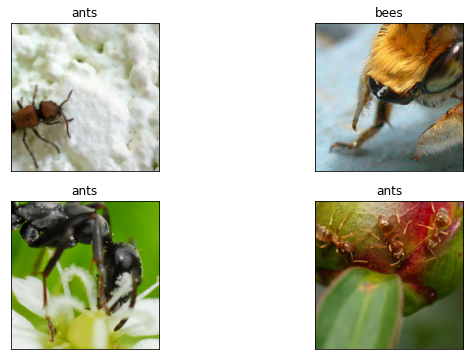

In [5]:
images, labels = iter(train_loader).next()
images = images.numpy()
fig = plt.figure(figsize=(10, 6))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size//2, idx+1, xticks=[], yticks=[])
    image = images[idx]
    image = image.transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    ax.imshow(image)
    ax.set_title("{}".format(class_names[labels[idx]]))

## Simple ResNet with passthrough skip connections
Let's first create a ResNet with no resizing of the dimensions in the main path, which means we can use simple skip connections that just pass the block input directly through an identity block without resizing it.

In [10]:
class ResNetSimple(nn.Module):

    def __init__(self):
        super().__init__()

        ### DOWNSCALING LAYER ###

        # Conv 1 layer: (3,224,224) -> (8,224,224)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1)
        # Conv1 layer output size = (W-F+2P)/S+1 = (224-3+2)/1+1 = 224
        # Batch norm
        self.bn1 = nn.BatchNorm2d(8)
        # Maxpool layer: (8,224,224) -> (8,112,112)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
        ### RESNET BLOCK 1 ###

        # Conv layer: (8,112,112) -> (8,112,112)
        self.block1conv1 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=1)
        # Batch norm
        self.block1bn1 = nn.BatchNorm2d(8)
        # Conv layer: (8,112,112) -> (8,112,112)
        self.block1conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=1)
        # Batch norm
        self.block1bn2 = nn.BatchNorm2d(8)

        ### RESNET BLOCK 2 ###

        # Conv layer: (8,112,112) -> (8,112,112)
        self.block2conv1 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=1)
        # Batch norm
        self.block2bn1 = nn.BatchNorm2d(8)
        # Conv layer: (8,112,112) -> (8,112,112)
        self.block2conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=1)
        # Batch norm
        self.block2bn2 = nn.BatchNorm2d(8)

        ### FINAL LAYERS ###

        # Average pooling layer: (8,112,112) -> (8,56,56)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        # Input size: 8 * 56 * 56 = 25088 from pooling layer
        # 2 output channels (for the 2 classes)
        self.fc1 = nn.Linear(8*56*56, 2)
        
    def forward(self, x):

        ### DOWNSCALING LAYER ###
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)

        ### RESNET BLOCK 1 ###
        skipconnect = x

        x_out = self.block1conv1(x) # conv1
        x_out = self.block1bn1(x_out) # batch norm 1
        x_out = F.relu(x_out) # relu

        x_out = self.block1conv2(x_out) # conv2
        x_out = self.block1bn2(x_out) # batch norm 2

        # Add layer and skipconnect, then activation
        x_out += skipconnect
        x_out = F.relu(x_out)

        ### RESNET BLOCK 2 ###
        skipconnect = x_out

        x_out = self.block2conv1(x_out) # conv1
        x_out = self.block2bn1(x_out) # batch norm 1
        x_out = F.relu(x_out) # relu

        x_out = self.block2conv2(x_out) # conv2
        x_out = self.block2bn2(x_out) # batch norm 2

        # Add layer and skipconnect, then activation
        x_out += skipconnect
        x_out = F.relu(x_out)

        ### FINAL LAYERS ###
        x_out = self.pool2(x_out)
        # Flatten into a vector to feed into linear layer
        x_out = x_out.view(x_out.size(0), -1)
        # Linear layer
        x_out = self.fc1(x_out)
        
        return x_out

In [11]:
# Instantiate the model
net = ResNetSimple()

# Display a summary of the layers of the model and output shape after each layer
summary(net,(images.shape[1:]),batch_size=batch_size,device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [4, 10, 224, 224]             280
         MaxPool2d-2          [4, 10, 112, 112]               0
            Conv2d-3          [4, 10, 112, 112]             910
       BatchNorm2d-4          [4, 10, 112, 112]              20
            Conv2d-5          [4, 10, 112, 112]             910
       BatchNorm2d-6          [4, 10, 112, 112]              20
            Conv2d-7          [4, 10, 112, 112]             910
       BatchNorm2d-8          [4, 10, 112, 112]              20
            Conv2d-9          [4, 10, 112, 112]             910
      BatchNorm2d-10          [4, 10, 112, 112]              20
        AvgPool2d-11            [4, 10, 56, 56]               0
           Linear-12                     [4, 2]          62,722
Total params: 66,722
Trainable params: 66,722
Non-trainable params: 0
---------------------------------

### Train the model

In [7]:
def train_model(model, criterion, optimizer, dataloaders, device, num_epochs=50):

    model = model.to(device) # Send model to GPU if available

    iter_num = {'train':0,'val':0} # Track total number of iterations

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Get the input images and labels, and send to GPU if available
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the weight gradients
                optimizer.zero_grad()

                # Forward pass to get outputs and calculate loss
                # Track gradient only for training data
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backpropagation to get the gradients with respect to each weight
                    # Only if in train
                    if phase == 'train':
                        loss.backward()
                        # Update the weights
                        optimizer.step()

                # Convert loss into a scalar and add it to running_loss
                running_loss += loss.item() * inputs.size(0)
                # Track number of correct predictions
                running_corrects += torch.sum(preds == labels.data)

                # Iterate count of iterations
                iter_num[phase] += 1

            # Calculate and display average loss and accuracy for the epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
    
    return

In [8]:
# Instantiate the model
net = ResNetSimple()

# Cross entropy loss combines softmax and nn.NLLLoss() in one single class.
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.Adam(net.parameters(),  lr=0.0001)

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_model(net, criterion, optimizer, dataloaders, device, num_epochs=100)

Epoch 0/29
----------
train Loss: 10.6756 Acc: 0.5738
val Loss: 4.9475 Acc: 0.5882
Epoch 1/29
----------
train Loss: 1.9703 Acc: 0.5738
val Loss: 0.8118 Acc: 0.5817
Epoch 2/29
----------
train Loss: 0.8699 Acc: 0.4959
val Loss: 0.7037 Acc: 0.5425
Epoch 3/29
----------
train Loss: 0.7078 Acc: 0.5328
val Loss: 0.6933 Acc: 0.4706
Epoch 4/29
----------
train Loss: 0.7031 Acc: 0.4959
val Loss: 0.6964 Acc: 0.4510
Epoch 5/29
----------
train Loss: 0.6881 Acc: 0.5451
val Loss: 0.6947 Acc: 0.4510
Epoch 6/29
----------
train Loss: 0.7055 Acc: 0.4877
val Loss: 0.6967 Acc: 0.4837
Epoch 7/29
----------
train Loss: 0.6989 Acc: 0.5041
val Loss: 0.6945 Acc: 0.4510
Epoch 8/29
----------
train Loss: 0.6850 Acc: 0.5000
val Loss: 0.6947 Acc: 0.4706
Epoch 9/29
----------
train Loss: 0.6897 Acc: 0.5369
val Loss: 0.6954 Acc: 0.5098
Epoch 10/29
----------
train Loss: 0.6794 Acc: 0.5246
val Loss: 0.7054 Acc: 0.4575
Epoch 11/29
----------


### Visualize results

In [ ]:
# Display a batch of predictions

def visualize_results(model,dataloader,device):
    model = model.to(device) # Send model to GPU if available
    with torch.no_grad():
        model.eval()
        # Get a batch of validation images
        images, labels = iter(val_loader).next()
        images, labels = images.to(device), labels.to(device)
        # Get predictions
        _,preds = torch.max(model(images), 1)
        preds = np.squeeze(preds.cpu().numpy())
        images = images.cpu().numpy()

    # Plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(15, 10))
    for idx in np.arange(len(preds)):
        ax = fig.add_subplot(2, len(preds)//2, idx+1, xticks=[], yticks=[])
        image = images[idx]
        image = image.transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        ax.imshow(image)
        ax.set_title("{} ({})".format(class_names[preds[idx]], class_names[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx] else "red"))
    return

visualize_results(net,val_loader,device)

## ResNet with resizing
Let's now create a new ResNet architecture which resizes the input dimensions in the main path.  This means we also need to apply a convolution layer in the skip connection to resize the data flowing through it, so that its dimensions match the dimensions of the data flowing through the main path (so that they can be combined).

In [ ]:
class ResNetResize(nn.Module):

    def __init__(self):
        super().__init__()

        ### DOWNSCALING LAYER ###

        # Conv 1 layer: (3,224,224) -> (8,224,224)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1)
        # Conv1 layer output size = (W-F+2P)/S+1 = (224-3+2)/1+1 = 224
        self.bn1 = nn.BatchNorm2d(8)
        
        ### RESNET BLOCK 1 ###

        # Main path
        # Conv layer: (8,224,224) -> (16,112,112)
        self.block1conv1 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1)
        self.block1bn1 = nn.BatchNorm2d(16)
        # Conv layer: (16,112,112) -> (16,112,112)
        self.block1conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.block1bn2 = nn.BatchNorm2d(16)

        # Skip connection: (8,224,224) -> (16,112,112)
        self.block1skipconv = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1)
        self.block1skipbn = nn.BatchNorm2d(16)

        ### RESNET BLOCK 2 ###

        # Main path
        # Conv layer: (16,112,112) -> (32,56,56)
        self.block2conv1 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.block2bn1 = nn.BatchNorm2d(32)
        # Conv layer: (32,56,56) -> (32,56,56)
        self.block2conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.block2bn2 = nn.BatchNorm2d(32)

        # Skip connection: (16,112,112) -> (32,56,56)
        self.block2skipconv = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.block2skipbn = nn.BatchNorm2d(32)

        ### FINAL LAYERS ###

        # Average pooling layer: (32,56,56) -> (32,28,28)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        # Input size: 32 * 28 * 28 = 25088 from pooling layer
        # 2 output channels (for the 2 classes)
        self.fc1 = nn.Linear(32*28*28, 2)
        
    def forward(self, x):

        ### DOWNSCALING LAYER ###
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        ### RESNET BLOCK 1 ###
        skipconnect = x
        skipconnect = self.block1skipconv(skipconnect)
        skipconnect = self.block1skipbn(skipconnect)

        x_out = self.block1conv1(x) # conv1
        x_out = self.block1bn1(x_out) # batch norm 1
        x_out = F.relu(x_out) # relu

        x_out = self.block1conv2(x_out) # conv2
        x_out = self.block1bn2(x_out) # batch norm 2

        # Add layer and skipconnect, then activation
        x_out += skipconnect
        x_out = F.relu(x_out)

        ### RESNET BLOCK 2 ###
        skipconnect = x_out
        skipconnect = self.block2skipconv(skipconnect)
        skipconnect = self.block2skipbn(skipconnect)

        x_out = self.block2conv1(x_out) # conv1
        x_out = self.block2bn1(x_out) # batch norm 1
        x_out = F.relu(x_out) # relu

        x_out = self.block2conv2(x_out) # conv2
        x_out = self.block2bn2(x_out) # batch norm 2

        # Add layer and skipconnect, then activation
        x_out += skipconnect
        x_out = F.relu(x_out)

        ### FINAL LAYERS ###
        x_out = self.pool2(x_out)
        # Flatten into a vector to feed into linear layer
        x_out = x_out.view(x_out.size(0), -1)
        # Linear layer
        x_out = self.fc1(x_out)
        
        return x_out

In [ ]:
# Instantiate the model
net = ResNetResize()

# Cross entropy loss combines softmax and nn.NLLLoss() in one single class.
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.Adam(net.parameters(),  lr=0.0001)

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_model(net, criterion, optimizer, dataloaders, device, num_epochs=100)